# Market Volatility Analysis

# 1) Environment & packages

Install packages (if needed):

Import libs at top of notebook:

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew, kurtosis
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

Set plotting defaults:

In [2]:
plt.rcParams['figure.figsize'] = (12,6)
sns.set(style='whitegrid')

# 2) Data gathering (yfinance)

Fetch daily adjusted close prices for all tickers and merge into one DataFrame.

In [7]:
tickers = ['BTC-USD', 'ETH-USD', '^NSEI', '^IXIC']
start = '2022-01-01'
end = '2025-11-15'

data = {}

for t in tickers:
    print("Downloading", t)
    df = yf.download(t, start=start, end=end, progress=False)

    # Use Adj Close if exists, otherwise Close
    series = df['Adj Close'] if 'Adj Close' in df.columns else df['Close']

    # Assign name to series (instead of rename)
    series.name = t

    data[t] = series

# Combine all into one DataFrame
prices = pd.concat(data.values(), axis=1)
prices.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_2868\2925909634.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, progress=False)
C:\Users\USER\AppData\Local\Temp\ipykernel_2868\2925909634.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, progress=False)


C:\Users\USER\AppData\Local\Temp\ipykernel_2868\2925909634.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, progress=False)


C:\Users\USER\AppData\Local\Temp\ipykernel_2868\2925909634.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=start, end=end, progress=False)


Ticker,BTC-USD,ETH-USD,^NSEI,^IXIC
Date,,,,
2022-01-01,47686.812500,3769.697021,NaN,NaN
2022-01-02,47345.218750,3829.564941,NaN,NaN
2022-01-03,46458.117188,3761.380371,17625.699219,15832.799805
2022-01-04,45897.574219,3794.056641,17805.250000,15622.719727
2022-01-05,43569.003906,3550.386963,17925.250000,15100.169922


# 3) Cleaning & alignment

Ensure same trading days (crypto trades 7/7, indices skip some days). We'll reindex to the union and forward-fill or interpolate.

In [9]:
# Reindex to business days or full calendar? Use business days if you prefer.
prices = prices.sort_index()

# Option A: forward-fill then back-fill (preserves latest known price on missing days)
prices_ffill = prices.ffill().bfill()

# Option B: interpolate (for small gaps)
# prices_interp = prices.interpolate(method='time')

prices = prices_ffill

Check missing values:

In [11]:
prices.isna().sum()

Ticker
BTC-USD    0
ETH-USD    0
^NSEI      0
^IXIC      0
dtype: int64

# 4) Feature creation: returns, log returns, rolling stats

Compute daily returns and log returns (prefer log returns for aggregation).

In [12]:
returns = prices.pct_change().dropna()
log_returns = np.log(prices).diff().dropna()

Rolling volatility and moving averages:

In [13]:
window = 20  # 20-day rolling (monthly-ish trading)
rolling_vol = log_returns.rolling(window).std() * np.sqrt(252)  # annualized
rolling_mean = log_returns.rolling(window).mean()

Store everything in a single panel:

In [14]:
# Example: flatten column names
returns.columns = [c + '_ret' for c in returns.columns]
log_returns.columns = [c + '_logret' for c in log_returns.columns]

df = pd.concat([prices, returns, log_returns, rolling_vol.add_suffix('_vol')], axis=1)
df = df.dropna()

In [16]:
prices.head()

Ticker,BTC-USD,ETH-USD,^NSEI,^IXIC
Date,,,,
2022-01-01,47686.812500,3769.697021,17625.699219,15832.799805
2022-01-02,47345.218750,3829.564941,17625.699219,15832.799805
2022-01-03,46458.117188,3761.380371,17625.699219,15832.799805
2022-01-04,45897.574219,3794.056641,17805.250000,15622.719727
2022-01-05,43569.003906,3550.386963,17925.250000,15100.169922


# 5) Exploratory Data Analysis (EDA)

Descriptive stats for returns:

In [17]:
desc = log_returns.describe().T
desc['skew'] = log_returns.skew()
desc['kurtosis'] = log_returns.kurtosis()
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
BTC-USD_logret,1413.0,0.000483,0.027176,-0.174053,-0.011802,-0.000096,0.013051,0.135764,-0.158613,4.472935
ETH-USD_logret,1413.0,-0.000138,0.036743,-0.191844,-0.017549,0.000149,0.017328,0.197200,-0.057727,4.113612
^NSEI_logret,1413.0,0.000273,0.007094,-0.061124,-0.001665,0.000000,0.002863,0.037472,-0.582500,8.558330
^IXIC_logret,1413.0,0.000261,0.012480,-0.061536,-0.002600,0.000000,0.004568,0.114784,0.143462,7.999688


Plot price series:

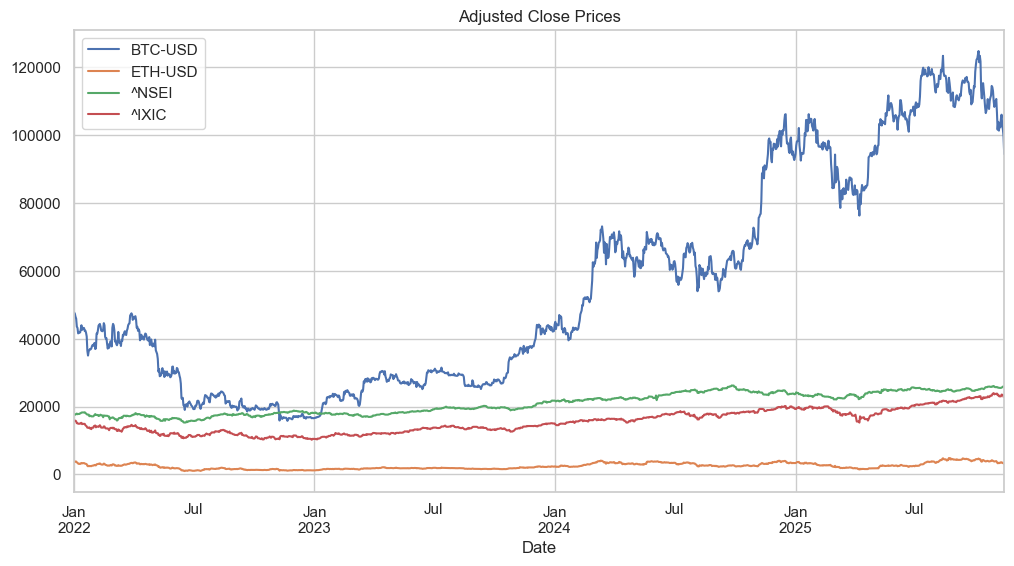

In [20]:
prices.plot(subplots=False, title='Adjusted Close Prices')
plt.legend()
plt.show()

Plot returns distribution (hist + KDE) per asset:

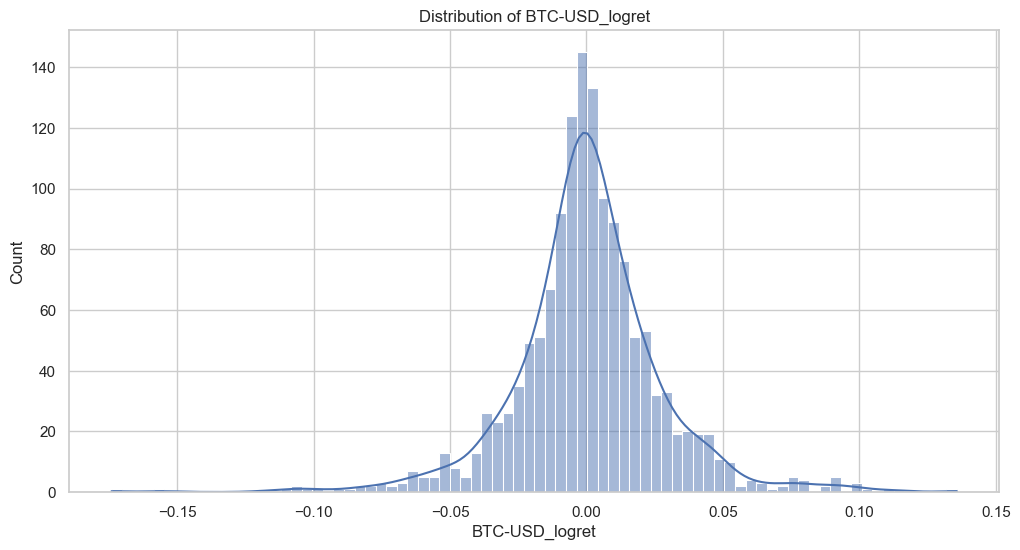

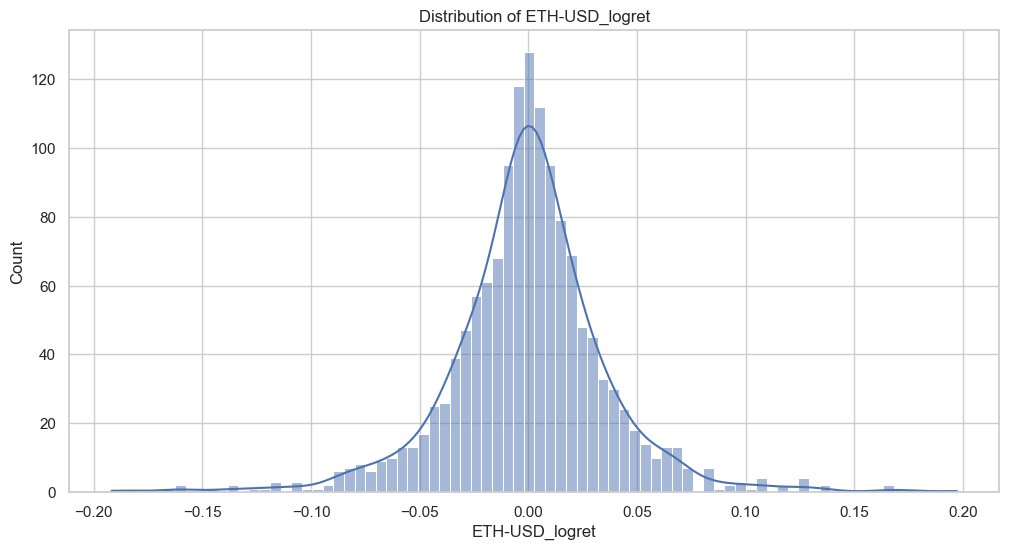

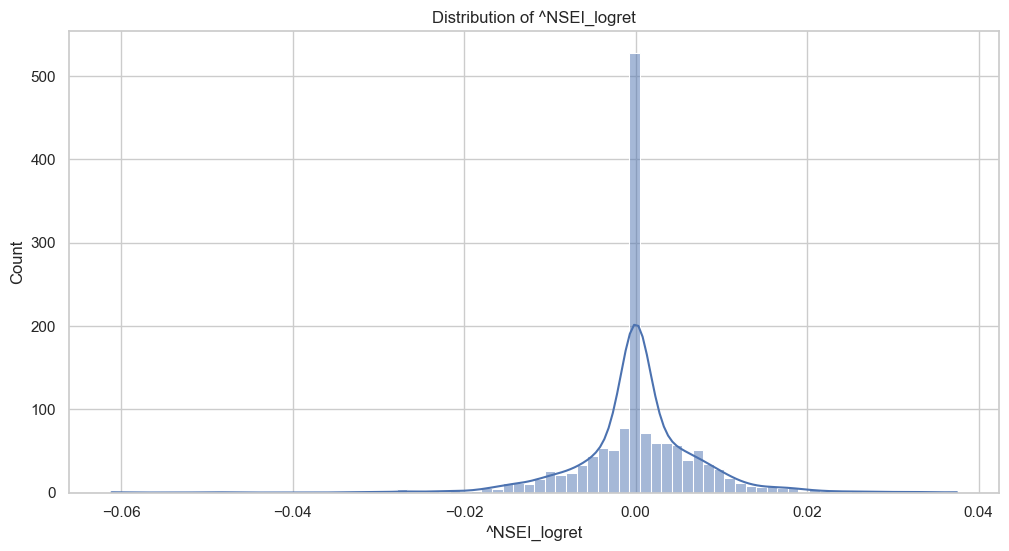

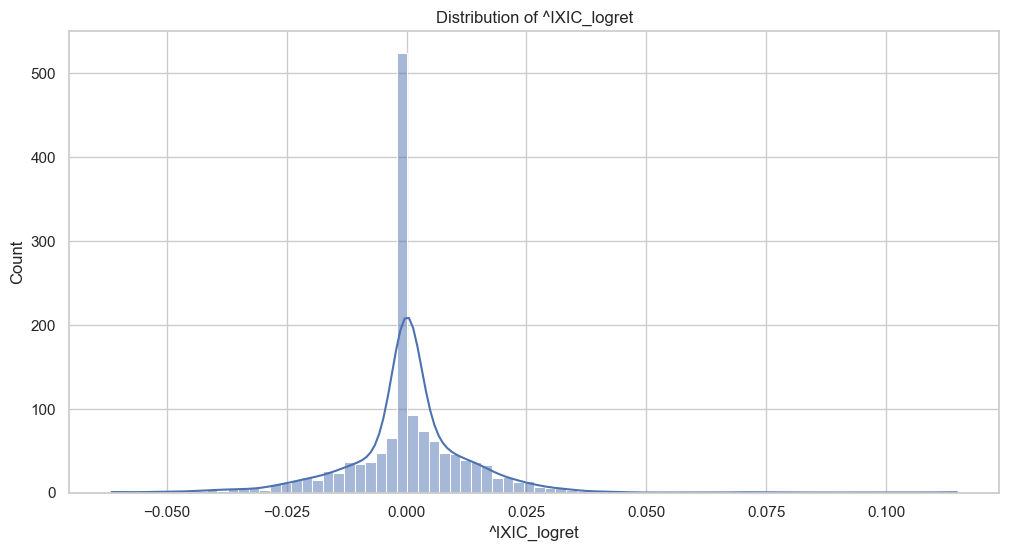

In [21]:
for col in log_returns.columns:
    plt.figure()
    sns.histplot(log_returns[col], kde=True, bins=80)
    plt.title(f'Distribution of {col}')
    plt.show()

Correlation heatmap (returns):

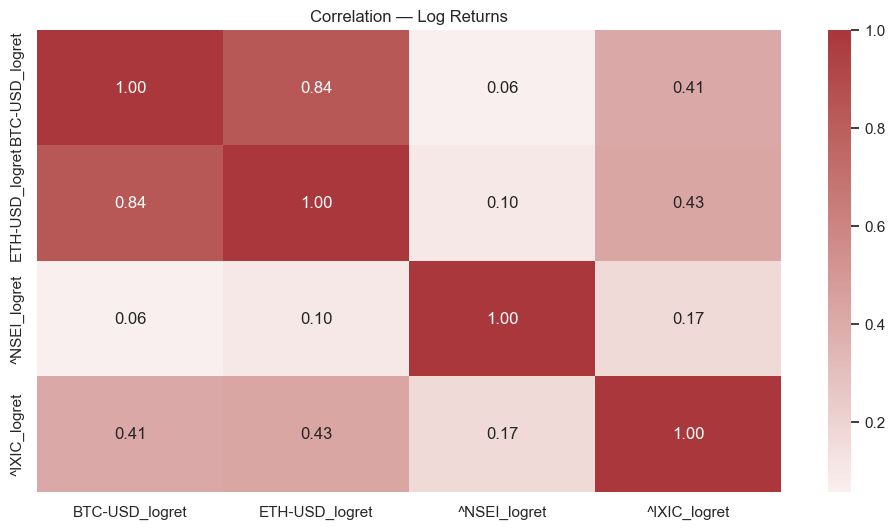

In [22]:
corr = log_returns.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation — Log Returns')
plt.show()

Rolling correlations (e.g., BTC vs NASDAQ):

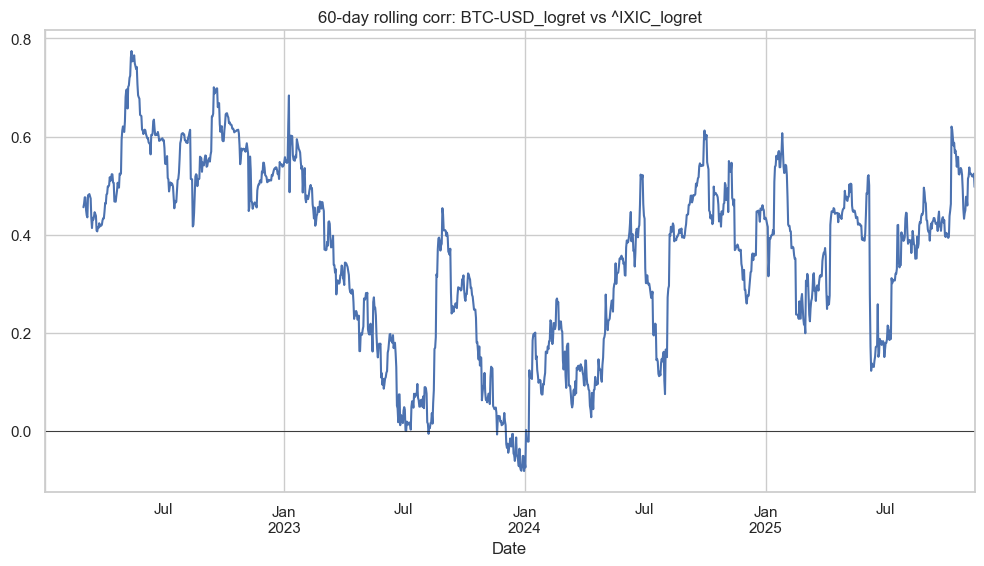

In [23]:
pair = ('BTC-USD_logret', '^IXIC_logret')  # adjust names to match your df
rolling_corr = log_returns[pair[0]].rolling(60).corr(log_returns[pair[1]])
rolling_corr.plot(title=f'60-day rolling corr: {pair[0]} vs {pair[1]}')
plt.axhline(0, color='black', lw=0.5)
plt.show()

# 6) Volatility & anomaly detection
Rolling volatility

Plot rolling volatility for each asset:

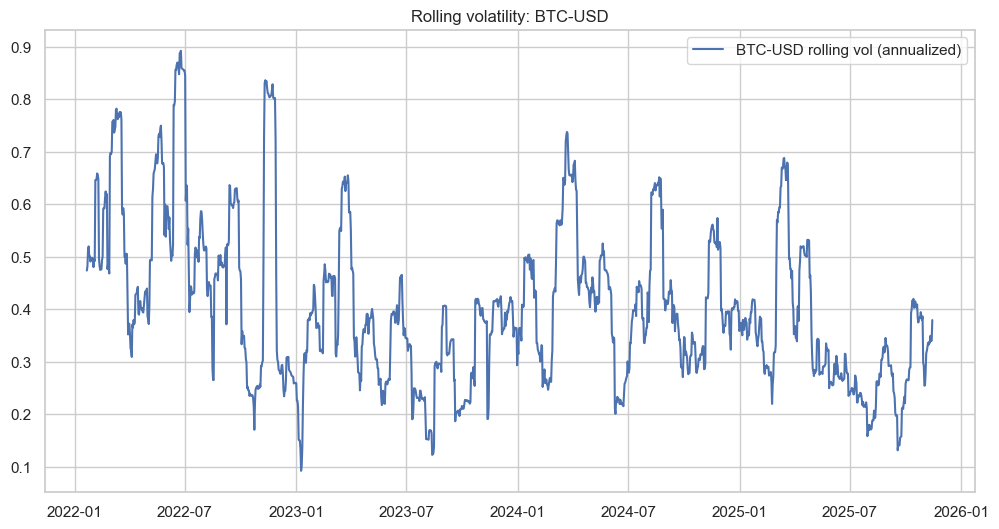

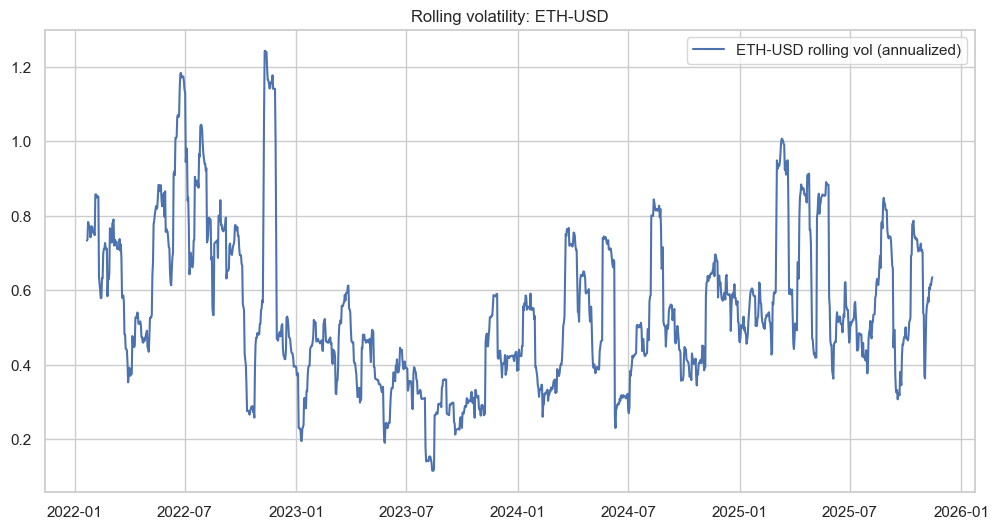

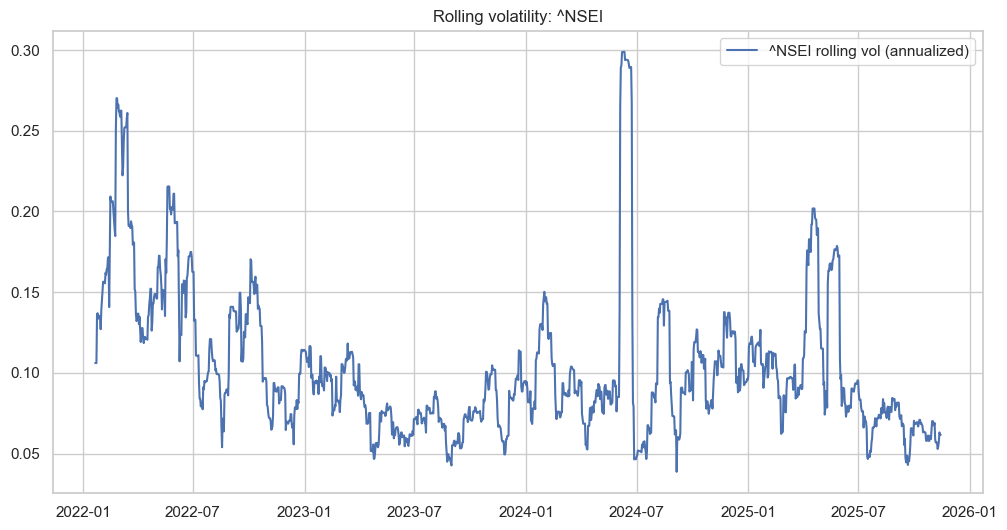

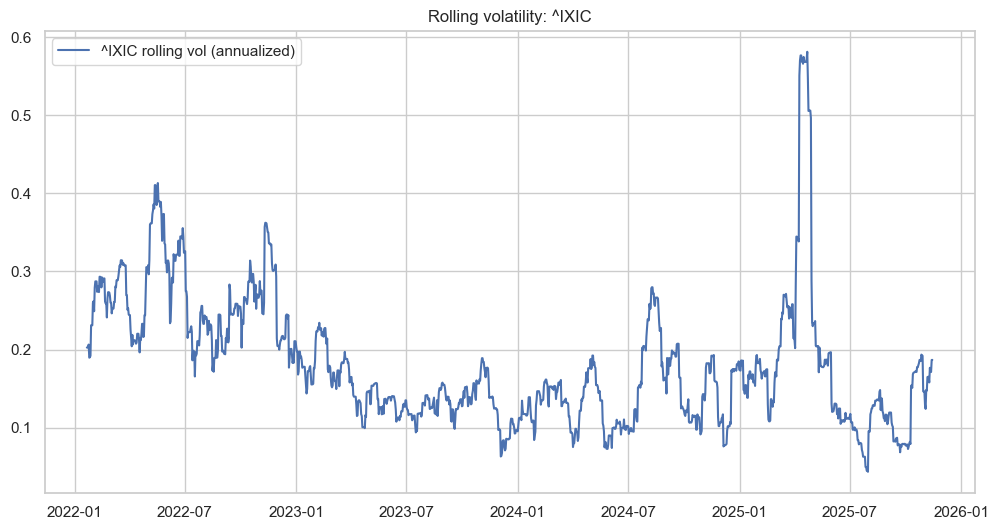

In [24]:
for asset in ['BTC-USD', 'ETH-USD', '^NSEI', '^IXIC']:
    col = asset + '_logret'
    vol_col = asset + '_vol'
    plt.figure()
    plt.plot(rolling_vol[asset], label=f'{asset} rolling vol (annualized)')
    plt.title(f'Rolling volatility: {asset}')
    plt.legend()
    plt.show()

Z-score anomaly detection (volatility spikes)

Compute z-score of rolling volatility and flag extreme days:

In [25]:
vol_z = rolling_vol.apply(lambda x: (x - x.mean())/x.std())
threshold = 3  # common choice
anomalies = (vol_z.abs() > threshold)
anomaly_days = anomalies.any(axis=1)
anomaly_dates = anomaly_days[anomaly_days].index
anomaly_dates[:10]

DatetimeIndex(['2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27',
               '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03',
               '2022-03-04', '2022-03-05'],
              dtype='datetime64[ns]', name='Date', freq=None)

List top volatility spikes per asset:

In [26]:
top_spikes = {}
for asset in rolling_vol.columns:
    top_spikes[asset] = rolling_vol[asset].nlargest(10)
top_spikes

{'BTC-USD': Date
 2022-06-25    0.892363
 2022-06-24    0.888669
 2022-06-23    0.887798
 2022-06-20    0.869882
 2022-06-19    0.869819
 2022-06-18    0.865237
 2022-06-26    0.859469
 2022-06-21    0.859405
 2022-06-27    0.858402
 2022-06-28    0.857577
 Name: BTC-USD, dtype: float64,
 'ETH-USD': Date
 2022-11-10    1.242541
 2022-11-11    1.242260
 2022-11-13    1.238990
 2022-11-12    1.236717
 2022-11-14    1.198001
 2022-06-25    1.183524
 2022-06-24    1.180101
 2022-11-23    1.176797
 2022-06-28    1.174069
 2022-06-29    1.173181
 Name: ETH-USD, dtype: float64,
 '^NSEI': Date
 2024-06-10    0.298890
 2024-06-11    0.298875
 2024-06-07    0.298714
 2024-06-08    0.298714
 2024-06-09    0.298714
 2024-06-14    0.293941
 2024-06-15    0.293941
 2024-06-13    0.293890
 2024-06-16    0.293861
 2024-06-12    0.293800
 Name: ^NSEI, dtype: float64,
 '^IXIC': Date
 2025-04-22    0.581333
 2025-04-11    0.576678
 2025-04-12    0.576678
 2025-04-16    0.574771
 2025-04-21    0.572206
 2

Z-score on returns (extreme returns)

You can also detect extreme returns using zscore on returns.

In [27]:
ret_z = log_returns.apply(zscore)
extreme_days = (ret_z.abs() > 3).any(axis=1)
extreme_days.sum(), extreme_days[extreme_days].head()

(np.int64(73),
 Date
 2022-01-21    True
 2022-01-24    True
 2022-02-03    True
 2022-02-04    True
 2022-02-14    True
 dtype: bool)

# 7) Correlation change before/after events

We need “events” — either manually annotate or use top spikes as anchor points. Example process:

1. Choose an event date (e.g., a big market drop).

2. Compute correlation in window before event (e.g., −60 to −1 days) and after event (+1 to +60 days).

3. Compare.

In [28]:
def corr_before_after(date, pair, window=60):
    d = pd.to_datetime(date)
    before = log_returns.loc[d - pd.Timedelta(days=window*1.5): d - pd.Timedelta(days=1)]
    after = log_returns.loc[d + pd.Timedelta(days=1): d + pd.Timedelta(days=window*1.5)]
    # Use business-day selection cleanly:
    before = before.tail(window)
    after = after.head(window)
    return before[pair].corr().iloc[0,1], after[pair].corr().iloc[0,1]

# Example usage (replace with a real event date):
# corr_before_after('2023-06-18', ['BTC-USD_logret', '^IXIC_logret'])

Interpretation: a big increase in correlation after a shock suggests contagion.

# 8) Statistical tests & additional analyses
Pearson & Spearman correlations

Use both to handle non-linear rank-based relationships.

In [29]:
pearson = log_returns.corr(method='pearson')
spearman = log_returns.corr(method='spearman')

Granger causality (optional / exploratory)

Test whether crypto returns Granger-cause stock returns (careful: requires stationary series).

In [30]:
# Example: does BTC predict NASDAQ?
data_gc = log_returns[['BTC-USD_logret','^IXIC_logret']].dropna()
# Granger test needs a 2-d ndarray and maxlag parameter.
grangercausalitytests(data_gc, maxlag=10, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1089  , p=0.0240  , df_denom=1409, df_num=1
ssr based chi2 test:   chi2=5.1197  , p=0.0237  , df=1
likelihood ratio test: chi2=5.1105  , p=0.0238  , df=1
parameter F test:         F=5.1089  , p=0.0240  , df_denom=1409, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6947  , p=0.0679  , df_denom=1406, df_num=2
ssr based chi2 test:   chi2=5.4085  , p=0.0669  , df=2
likelihood ratio test: chi2=5.3982  , p=0.0673  , df=2
parameter F test:         F=2.6947  , p=0.0679  , df_denom=1406, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0999  , p=0.0984  , df_denom=1403, df_num=3
ssr based chi2 test:   chi2=6.3312  , p=0.0966  , df=3
likelihood ratio test: chi2=6.3170  , p=0.0972  , df=3
parameter F test:         F=2.0999  , p=0.0984  , df_denom=1403, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9525  , p=0.

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(5.108862425197376),
    np.float64(0.023956017094161272),
    np.float64(1409.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(5.119740059885518),
    np.float64(0.023655159794866494),
    np.int64(1)),
   'lrtest': (np.float64(5.1104806584316975),
    np.float64(0.02378173072103953),
    np.int64(1)),
   'params_ftest': (np.float64(5.108862425197264),
    np.float64(0.02395601709416587),
    np.float64(1409.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.694664844978782),
    np.float64(0.0679139678836144),
    np.float64(1406.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(5.40849515827178),
    np.float64(0.06692065740708168),
    np.int64(2)),
   'lrtest': (np.float64(5.398155936394687),
    np.float64(0.06726750693572779),
    np.int64(2)),
   'params_ftest': (np.float64(2.6946648449789343),
    np.float64(0.06791396788360285),
    np.float64(1406.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],


Interpret Granger outputs with caution — not proof of true causality, just predictive precedence.

Change point detection (optional)

You can use rolling statistics or packages like ruptures to detect structural breaks in volatility or correlation.

# 9) Visualizations (presentation-ready)

Dual-axis chart: price + volatility.

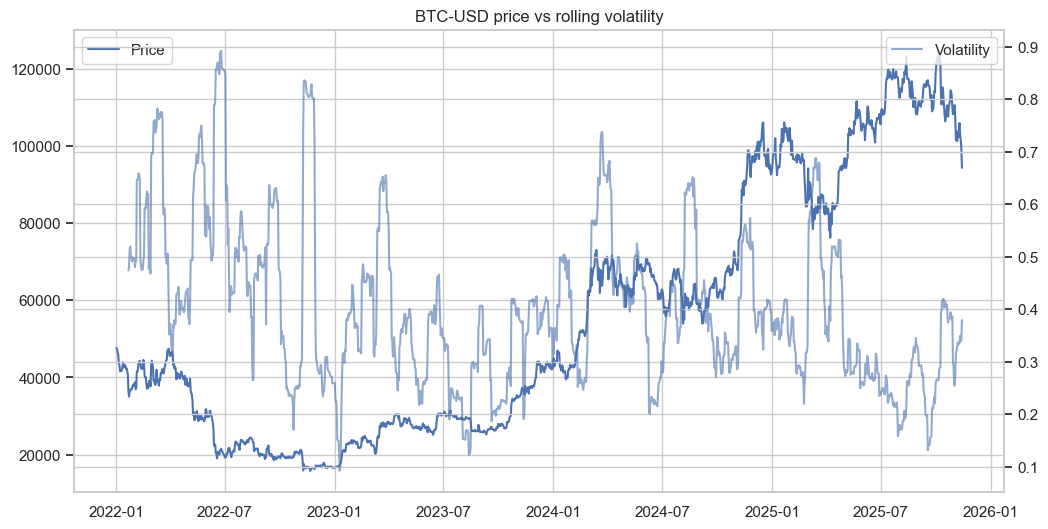

In [31]:
asset = 'BTC-USD'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(prices[asset], label='Price')
ax2.plot(rolling_vol[asset], label='Volatility', alpha=0.6)
ax1.set_title(f'{asset} price vs rolling volatility')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Heatmap: correlation matrix of returns (already shown).

Annotated timeline: mark anomaly dates on the price chart:

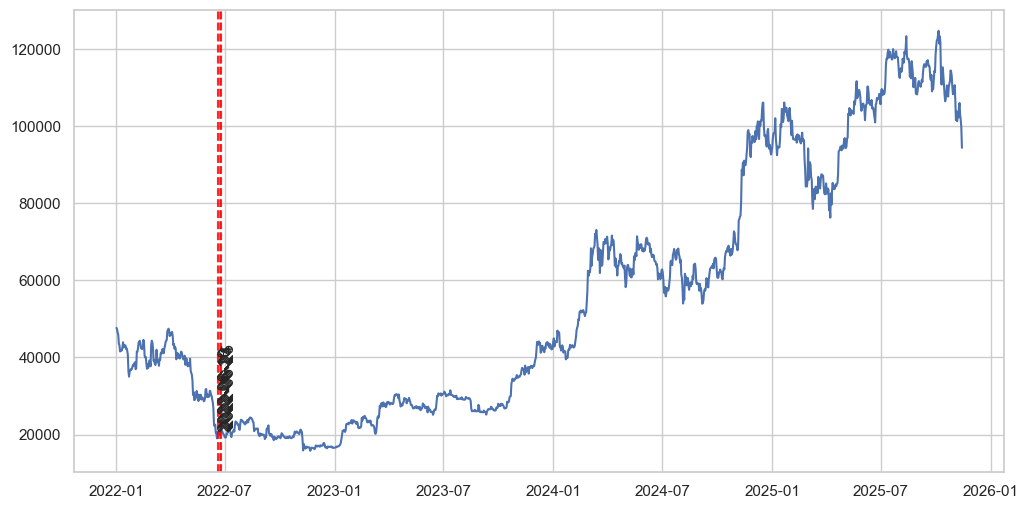

In [32]:
# Annotate top volatility days
top_dates = rolling_vol['BTC-USD'].nlargest(5).index
plt.plot(prices['BTC-USD'])
for d in top_dates:
    plt.axvline(d, color='red', linestyle='--', alpha=0.6)
    plt.text(d, prices['BTC-USD'].loc[d]*1.05, d.strftime('%Y-%m-%d'), rotation=90)
plt.show()

Rolling correlation panel: rolling correlation for pairs (BTC vs ETH, BTC vs NIFTY, BTC vs NASDAQ). Small-multiples with same y-axis range to compare.